# Continuous NMR analysis

Use this template as a starting point to carry out the analysis tasks.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

## Standard Packages

This is a good idea at the beginning of your notebook to include the packages that you will need.  We will use those shown below here.  A brief description:
* `numpy` is the foundational package for Python numerical work. It extends and speeds up array operations beyond standard Python, and it includes almost all math functions that you would need for example `sqrt()` (square root) or `cos()` (cosine).  These would be written in code as `np.sqrt()` or `np.cos()`.
* `scipy` is a huge collection of scientific data analysis functions, routines, physicical constants, etc.  This is the second most used package for scientific work. Here we will use the physical constants library, `scipy.constants`.  Documentation is at [SciPy.org](https://docs.scipy.org/doc/scipy/reference/) with the constants subpackage at https://docs.scipy.org/doc/scipy/reference/constants.html.
* `uncertainties` is a very useful small package that simplifies uncertainty propagation and printing out of quantities with uncertainty. Documentation is at https://pythonhosted.org/uncertainties/
* `matplotlib` is *the* standard plotting package for scientific Python.  We will use a subset called `pyplot` which is modeled after the plotting functions used in MATLAB. The last line below, `%matplotlib inline`, simply forces the plots to appear within the notebook.
* `pandas` is a large data science package.  It's main feature is a set of methods to create and manipulate a "DataFrame," which is an enlargement of the idea of an array.  I plays well with NumPy and other packages.  We will use it mainly as a way to read files into data sets in an easy way.
* [LMFit](https://lmfit.github.io/lmfit-py/) is excellent for carrying out line and curve fits with many useful features.

## Getting Help

See the example code for a wide range of actions in notebooks created by Prof. Marjorie Olmstead and Prof. David Pengra in this repository: [**Physics431/Examples**](https://github.com/Physics431/Examples).

You can pull the examples into your environment with the following command.  (Only do this once, or you will get an error):

    git clone https://github.com/Physics431/Examples

## Task Summary

#### Measure $\gamma$ for protons
1. Import measurements of frequency and magnetic field taken multiple times (5-10) in order to establish uncertainty of individual measurements.  
2. Calculate the mean and standard deviation of each set of measurements.  Also calculate the percent uncetainty in each set. Use these results to establish uncertainties on the rest of the data points.
3. Import measurements of the resonant frequency $f_{\rm res}$ vs. static field $B_0$ for protons in water (+CuSO<sub>4</sub>) across the range of frequencies available with the oscillator.  
4. Include the uncertainty calculated in step 2.
5. Make a line fit and a plot of the data with the fit (use LMfit) to get the slope of $f_{\rm res}$ versus $B_0$.
6. Calculate $\gamma$ and the $g$-factor for the proton, including uncertainty.

#### Measure the resonance of <sup>19</sup>F versus <sup>1</sup>H
1. Import measurements listing measured B-field along with resonant frequencies of <sup>1</sup>H and <sup>19</sup>F at those field strengths.
2. Fit a line to the resonant frequency of <sup>19</sup>F versus resonant frequency of <sup>1</sup>H from the above data set, plot it (use LMfit) and obtain slope and its uncertainty.
3. From the results calculate $\gamma$ and associated $g$-factor for <sup>19</sup>F from the fit result and the accepted values known for <sup>1</sup>H.
4. Comment in your Group Notebook on the topic of observable chemical shift for fluorine

#### Trend of $T_2^*$ with paramagnetic ion concentration
If you can get quantitative values for how $T_2^*$ decays for a range of concentration, make a plot to see the trend.


In [259]:
# Usually import packages via a handle to the functions in them using import ... as ...
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uncertainties as unc
import scipy.constants as const
%matplotlib inline

def r4(arr):
    def round_to_sigfigs(number, sigfigs=4):
        if number == 0:
            return 0
        # Calculate the order of magnitude of the number
        order_of_magnitude = np.floor(np.log10(abs(number)))
        # Scale the number to shift significant figures to integer range
        scale_factor = 10 ** (sigfigs - 1 - order_of_magnitude)
        # Round to nearest integer at the scaled level
        rounded = col_round(number * scale_factor)
        # Scale back to original magnitude
        return rounded / scale_factor

    vectorized_round = np.vectorize(round_to_sigfigs)
    return vectorized_round(arr)

def col_round(x):
  frac = x - np.floor(x)
  if frac < 0.5: return np.floor(x)
  return np.ceil(x)

r4(8.1665)
col_round(8.1665*1000)


8166.0

In [260]:
# Useful plot default
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

## Magnetic moment of the proton

### Read in the multi-measurement data

You should have a spreadsheet (CSV) with columns or rows of like measurements of frequency and field for a set of steady fields (at least 3 sets of 10 across the range of useable oscillator frequencies).  Import these data with Pandas `pd.read_csv()`:
    
    multi_data = pd.read_csv('multi-measurement_NMR_data.csv')


In [276]:
# Read in the data to a Pandas dataframe and print a table.
df = pd.read_csv('exercise 1 calibration.csv')
df

,B1,F1,B2,F2,B3,F3
0,1.9,8.111428,2.2,9.386036,2.6,11.097345
1,NaN,8.116436,NaN,9.388261,NaN,11.096828
2,NaN,8.118151,NaN,9.388306,NaN,11.096747
3,NaN,8.118828,NaN,9.388379,NaN,11.095028
4,NaN,8.114294,NaN,9.388353,NaN,11.096786
5,NaN,8.114070,NaN,9.388555,NaN,11.098098
6,NaN,8.110793,NaN,9.389152,NaN,11.098345
7,NaN,8.111696,NaN,9.389538,NaN,11.098362
8,NaN,8.112077,NaN,9.389313,NaN,11.098183
9,NaN,8.112108,NaN,9.389308,NaN,11.098050


If the multiple measurements in the dataframe `df` are in a column with name `'col_name'` you an calculat the mean and standard deviation with the internal methods like this:

    col_mean = df['col_name'].mean()
    col_std_dev = df['col_name'].std()
    
Then the percent uncertainty is just the ratio of the standard deviation to the mean ($\times$100).  Calculate this too.

In [277]:
# Calculate the requested quantities
class measure:
    def __init__(self, df, bname, mname):
        self.b = df[bname].values[0]
        self.m = df[mname]
        self.fmean = self.m.mean()
        self.fstd = self.m.std()
        self.uncert = self.fstd/self.fmean * 100

m1 = measure(df, 'B1', 'F1')
m2 = measure(df, 'B2', 'F2')
m3 = measure(df, 'B3', 'F3')
measurements = [m1, m2, m3]


B1 =  1.9


If the standard deviations are (nearly) the same, you can use one number for the uncertainty in a frequency or field measurement.  If they are different, check the percent uncertainty.  If these are (nearly) the same, then the data-point uncertainty can be given by the value times this percent uncertainty. If these are different, then you should use an interpolation function to calculate the uncertainty in a data point.

The Python libraries provide just such a function: the **SciPy** `interpolate` package, which you can read about here: [SciPy Interpolate](https://docs.scipy.org/doc/scipy/reference/reference/interpolate.html).

The SciPy function to use is `interp1d()`.  Notice that it creates a *function*. To create the interpolation function, you feed it your feed it your list of uncertainties versus frequency or uncertainties versus field, then use the result with your array of values of $f_{\rm res}$ versus $B_0$ to obtain the uncertainty for each data point.

In [279]:
# Make a table of the uncertainty calculation to easily compare the values across the measurement range.
means = np.array([m.fmean for m in measurements])
bs = np.array([m.b for m in measurements])
sigmas = np.array([m.fstd for m in measurements])
uncerts = np.array([m.uncert for m in measurements])
print(means)
print(sigmas)
print(uncerts)

#these standard deviations are close enough

[ 8.1139881  9.3885201 11.0973772]
[0.0029069  0.00100098 0.00105914]
[0.03582575 0.01066176 0.00954409]


### Read in the resonance data for protons

Use `read_csv()` as before.  You should have a table with at least 2 columns: resonance frequency and magnetic field. 

Print a table.

In [280]:
df2 = pd.read_csv('exercise 1 data.csv')
df2


,B (kG),f_res (MHz)
0,1.500,6.402169
1,1.600,6.831075
2,1.700,7.255109
3,1.800,7.685127
4,1.900,8.112426
5,2.000,8.536764
6,2.100,8.964888
7,2.200,9.392011
8,2.300,9.815596
9,2.401,10.247742


In [283]:
# Based on the result of the uncertainty analysis above, construct uncertainty arrays
# to go with the data according to those instructions.
# Include the uncertainty results as another column in the dataframe 
Bvals = df2['B (kG)'].values
freqs = df2['f_res (MHz)'].values
# Read in the data, and print the dataframe
stdev = np.interp(Bvals, bs, sigmas)
print(stdev)

[0.0029069  0.0029069  0.0029069  0.0029069  0.0029069  0.00227159
 0.00163629 0.00100098 0.00101552 0.00103021 0.00104475 0.00105914
 0.00105914 0.00105914]


### Fit the data to extract the slope

Use LMfit.  See the examples.

In [263]:
# Set  up the Model

# Import the Linear model.
# You only do this once in a notebook
from lmfit.models import LinearModel

# create an instance of the model
# You only need to do this once
line = LinearModel()
start_params = line.guess(y_data, x=x_data

ModuleNotFoundError: No module named 'lmfit'

In [264]:
# Get starting parameters.  Example:
# start_params = line.guess(y_data, x=x_data

# Feed these into the fitter and run it. Example:
# Line_fit = line.fit(y_data, start_params, x=x_data, weights=1/y_data_unc)

# Print the fit results. Example
# Line_fit

In [265]:
# Make a plot.  Example
# Line_fit.plot()
# plt.grid(True)
# plt.title('NMR resonance measurement for protons')
# plt.xlabel('Magnetic field (kG)')
# plt.ylabel('Resonant frequency (MHz)');

### Extract the slope with uncertainty from the fit parameters


In [266]:
# Example
# proton_slope = unc.ufloat(Line_fit.params['slope'].value, Line_fit.params['slope'].stderr,'proton_slope')
# print('gamma for protons = {:.2uP} MHz/kG'.format(proton_slope))

Calculate $\gamma$ in rad/(s-T) to compare to accepted values.  Use the conversion constants in `scipy.constants` 


In [267]:
# Here is an example of how to access the scipy.constants

expected_gamma = const.value('nuclear magneton in MHz/T')*const.value('proton g factor')
print('Expected value of gamma for proton: {:.6g} MHz/T'.format(expected_gamma))

Expected value of gamma for proton: 42.5775 MHz/T


Calculate the proton $g$-factor from your result and compare to the expected value.

In [268]:
# You code this


## B field inhomogeneity

### Read in the data

Also, print a table.

In [269]:
df = pd.read_csv('Exercise 2.csv')
df

,Position,Freq
0,1,10.029039
1,2,10.029181
2,3,10.033338
3,4,10.033736
4,5,10.033707
5,6,10.043256
6,7,10.034960
7,8,10.037377
8,9,10.037123
9,10,10.030688


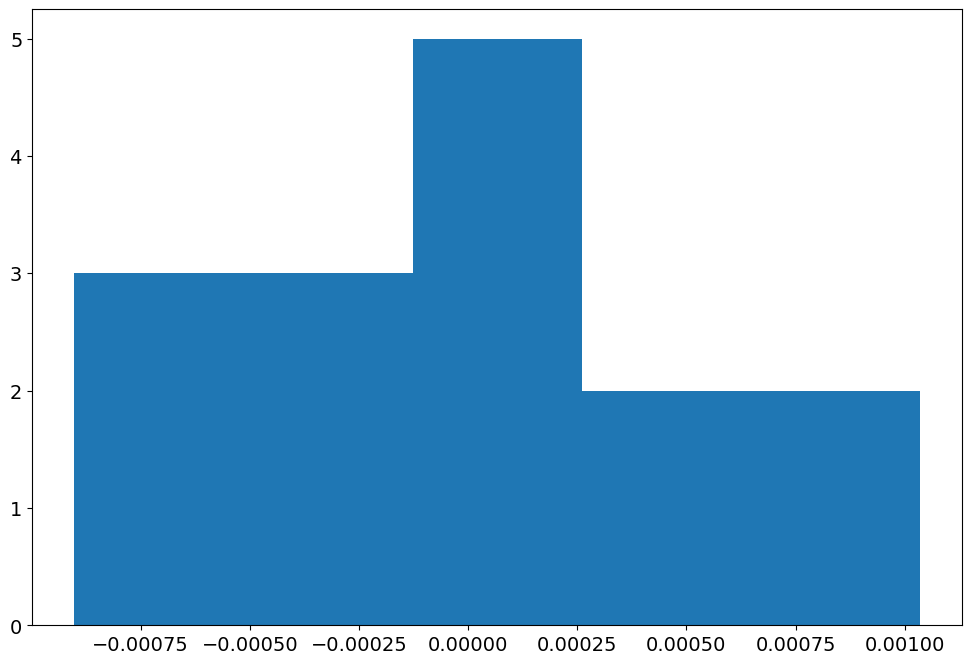

In [270]:
#making a histogram
plt.figure()
B = df['Freq'].values/expected_gamma
Bz = (B-np.mean(B))/np.mean(B)
plt.hist(Bz, bins=5)
plt.show()

## Fluorine-19 versus Proton (Hydrogen-1) resonance

### Read in the data

Also, print a table.

In [271]:
# Use pd.read_csv(), as you did earlier


### Plot and fit the data.  

BUT: Here you are comparing the resonant frequencies only!  The magnetic field measurement does not matter, as long as it is stable between the two frequency measurements for each data point

In [272]:
# Make a fit and plot of fluorine resonant frequency versus hydrogen resonant frequency.


### Use the result

Obtain the slope with uncertainty and with the result calculate a value for $\gamma_F$ and the <sup>19</sup>F $g$-factor. 

In [273]:
# You code this


## Trend of $T_2^*$ as a function of paramagnetic ion concentration

From the scope screen images, extract estimates of the relaxation time $T_2^*$ as a function of concentration of the copper sulfate ions.  

Plot these on a plot with double-log axes.  To change the axis type of a plot use the functions

    plt.xscale('log')
    plt.yscale('log')
    
You should see a trend that the relaxation time gets a bit longer and then levels out as the concentration is decreased.

In [274]:
# You code this
